In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
import plotting as myP
import numpy as np
import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read AGN Lists From CSV

In [3]:
# read AGN ID and index from csv files
agn_irSel20 = np.array(myP.ReadFile(path_csv+'\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv'),    dtype=int)
agn_xrSel20 = np.array(myP.ReadFile(path_csv+'\Match_Chandra2016_XrayAGN_to_COSMOS2020.csv'), dtype=int)

# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
agn_xrSel20_id, agn_xrSel20_i = agn_xrSel20.T

Cropped:  ['ID', 'i']
Cropped:  ['ID', 'i']


In [4]:
# print info
print('Number of IR AGN in COSMOS 2020:\t',    len(agn_irSel20_id))
print('Number of Xray AGN in COSMOS 2020:\t',  len(agn_xrSel20_id))

Number of IR AGN in COSMOS 2020:	 1533
Number of Xray AGN in COSMOS 2020:	 2176


# Get Redshifts

In [5]:
# read redshifts
zAll = np.array(myP.ReadFile(path_cat+'\COSMOS_z_matches.csv'))
zID, zZ = zAll.T
# get correct data type
zID = np.array(zID, dtype=int)
zZ  = np.array(zZ,  dtype=float)
# apply mask to remove bad redshifts
mask_z = (zZ >= 0) & (zZ < 99)
zID = zID[mask_z]
zZ  = zZ[mask_z]
# print info
print('Number of sources w/ z:', len(zID))

Cropped:  ['ID', 'z']
Number of sources w/ z: 485793


In [6]:
# get 0<z<1
mask_z01 = (zZ > 0.0) & (zZ <= 1.0)
zID_01 = zID[mask_z01]
zZ_01  = zZ[mask_z01]
# print info
print('Number of sources w/ 0<z<1:', len(zID_01))

Number of sources w/ 0<z<1: 211361


# Get Data From Catalogs

In [7]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()

In [8]:
# get IRAC data (unit = 'uJy')
ch1_data  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('Ch1 read')
ch2_data  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('Ch2 read')
ch3_data  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('Ch3 read')
ch4_data  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('Ch4 read')
# get ID
id20_data = np.array(data20['ID_COSMOS2015'])
print('id read')
# Get Far-InfraRed (FIR) data at 24um
fir24um_data = np.array(data20['FIR_24_FLUX'])   # Spitzer/MIPS.24mu
print('24um read')
fir24umErr_data = np.array(data20['FIR_24_FLUXERR'])   # Spitzer/MIPS.24mu
print('24um err read')

Ch1 read
Ch2 read
Ch3 read
Ch4 read
id read
24um read
24um err read


In [9]:
# open COSMOS 2016 catalog file and get data 
inf16 = fits.open(path_cat+'\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
data16 = inf16[1].data
cols16 = inf16[1].columns
inf16.close()

In [10]:
# get data arrays from columns
id16_data = np.array(data16['id_k_uv'])
print('id read')
L0510_data = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('L0510 read')
k0510_data = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('abs_corr_0510 read')

id read
L0510 read
abs_corr_0510 read


# Isolate Data By Selection Method

In [11]:
# match agn ids
key_ir, key_xr = match.match(agn_irSel20_id, agn_xrSel20_id)

# initialize
mask_ir = np.ones(agn_irSel20_id.size, dtype=bool)
mask_xr = np.ones(agn_xrSel20_id.size, dtype=bool)

# set matched index to false
mask_ir[key_ir] = False
mask_xr[key_xr] = False

# remove xray selected agn from ir selected list
agn_irSel20_id_ONLY = agn_irSel20_id[mask_ir]
agn_irSel20_i_ONLY  = agn_irSel20_i[mask_ir]

# remove ir selected agn from xray selected list 
agn_xrSel20_id_ONLY = agn_xrSel20_id[mask_xr]
agn_xrSel20_i_ONLY  = agn_xrSel20_i[mask_xr]

# create list of ir/xray match
agn20_id_BOTH = agn_irSel20_id[key_ir]
agn20_i_BOTH  = agn_irSel20_i[key_ir]

In [12]:
# print info 
print('Number of IR only:\t',   len(agn_irSel20_id_ONLY))
print('Number of Xray only:\t', len(agn_xrSel20_id_ONLY))
print('Number of matches:\t',   len(agn20_id_BOTH))

Number of IR only:	 886
Number of Xray only:	 1529
Number of matches:	 647


In [13]:
# returns the IRAC channels only at indeces i 
def SelectIRAC(i, applyMask=True, printInfo=True):
    # get data
    a = ch1_data[i]
    b = ch2_data[i]
    c = ch3_data[i]
    d = ch4_data[i]

    mask = []
    if(applyMask) :
        # mask bad values 
        mask = (a > 0) & (b > 0) & (c > 0) & (d > 0)
        # apply mask 
        a = a[mask]
        b = b[mask]
        c = c[mask]
        d = d[mask] 

    if(printInfo) : 
        # print info
        print('Col \t Min \t\t Max \t\t Count')
        print('-------------------------------------------------------------')
        print('CH1 \t', min(a), '\t', max(a), '\t', len(a))
        print('CH2 \t', min(b), '\t', max(b), '\t', len(b))
        print('CH3 \t', min(c), '\t', max(c), '\t', len(c))
        print('CH4 \t', min(d), '\t', max(d), '\t', len(d))
        print('-------------------------------------------------------------')
    
    # return data 
    if(applyMask) : 
        return a,b,c,d, mask
    else : 
        return a,b,c,d

In [14]:
# filter data by selection method
ch1_ir, ch2_ir, ch3_ir, ch4_ir, mask_ir = SelectIRAC(agn_irSel20_i_ONLY, True, False)
ch1_xr, ch2_xr, ch3_xr, ch4_xr, mask_xr = SelectIRAC(agn_xrSel20_i_ONLY, True, False)
ch1_ix, ch2_ix, ch3_ix, ch4_ix, mask_ix = SelectIRAC(agn20_i_BOTH, True, False)

# get ids for data with detections in all IRAC bands 
agn_irSel20_id_ONLY_IRAC = agn_irSel20_id_ONLY[mask_ir]
agn_xrSel20_id_ONLY_IRAC = agn_xrSel20_id_ONLY[mask_xr]
agn20_id_BOTH_IRAC       = agn20_id_BOTH[mask_ix]

# get ids for X-ray selected AGN with no IRAC detections
agn_xrSel20_id_ONLY_NOIRAC = set(agn_xrSel20_id_ONLY) - set(agn_xrSel20_id_ONLY_IRAC)

# print info 
print('Number of IR only w/ IRAC:\t',   len(agn_irSel20_id_ONLY_IRAC))
print('Number of Xray only w/ IRAC:\t', len(agn_xrSel20_id_ONLY_IRAC))
print('Number of Xray only w/o IRAC:\t',len(agn_xrSel20_id_ONLY_NOIRAC))
print('Number of matches w/ IRAC:\t',   len(agn20_id_BOTH_IRAC))

Number of IR only w/ IRAC:	 886
Number of Xray only w/ IRAC:	 1378
Number of Xray only w/o IRAC:	 151
Number of matches w/ IRAC:	 647


# Plot IRAC Colors With Exclusive Selection Lists

In [15]:
myP.SetStyle()

In [16]:
# calculate colors for ir 
x_ir = np.log10( ch3_ir / ch1_ir ) # x = log10 ( f_5.6um / f_3.6um )
y_ir = np.log10( ch4_ir / ch2_ir ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for xray 
x_xr = np.log10( ch3_xr / ch1_xr ) # x = log10 ( f_5.6um / f_3.6um )
y_xr = np.log10( ch4_xr / ch2_xr ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for matched ir/xray
x_ix = np.log10( ch3_ix / ch1_ix ) # x = log10 ( f_5.6um / f_3.6um )
y_ix = np.log10( ch4_ix / ch2_ix ) # y = log10 ( f_8.0um / f_4.5 um )

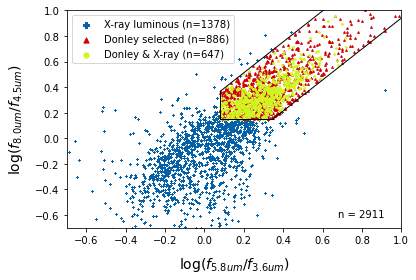

Number of IR only:	 886
Number of Xray only:	 1378
Number of matches:	 647
Total Number:		 2911
68.04938271604938 % of Xray sources fall outside wedge.
57.79517286366601 % of IR souces have no Xray greater than 10^43


In [17]:
myP.PlotDonleyTricolor(
        x_xr, y_xr,             # X-ray (blue)
        x_ir, y_ir,             # infrared (red)
        x_ix, y_ix,             # overlap (yellow)
        path=path_fig,                          # save
        fileName='COSMOS_IR-Xray_selection',    # save
        printInfo=True          # output text
    ) 

# Isolate sources with redshifts 0<z<1

In [18]:
# match redshift against AGN color IDs
key_z_blu, key_blu_z= match.match(zID_01, agn_xrSel20_id_ONLY_IRAC) 
key_z_red, key_red_z= match.match(zID_01, agn_irSel20_id_ONLY_IRAC)
key_z_yel, key_yel_z= match.match(zID_01, agn20_id_BOTH_IRAC)

# get sources with redshifts 0<z<1
x_xr_z01 = x_xr[key_blu_z]
y_xr_z01 = y_xr[key_blu_z]
x_ir_z01 = x_ir[key_red_z] 
y_ir_z01 = y_ir[key_red_z]
x_ix_z01 = x_ix[key_yel_z] 
y_ix_z01 = y_ix[key_yel_z]

# print info 
print('Number of IR only w/ IRAC and 0<z<1:\t',   len(x_ir_z01))
print('Number of Xray only w/ IRAC and 0<z<1:\t', len(x_xr_z01))
print('Number of matches w/ IRAC and 0<z<1:\t',   len(x_ix_z01))

Number of IR only w/ IRAC and 0<z<1:	 274
Number of Xray only w/ IRAC and 0<z<1:	 352
Number of matches w/ IRAC and 0<z<1:	 107


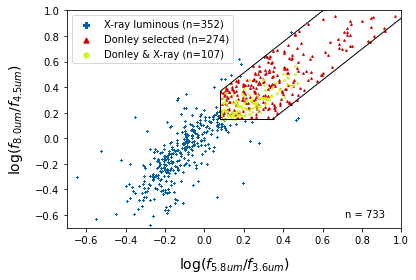

Number of IR only:	 274
Number of Xray only:	 352
Number of matches:	 107
Total Number:		 733
76.68845315904139 % of Xray sources fall outside wedge.
71.91601049868767 % of IR souces have no Xray greater than 10^43


In [19]:
myP.PlotDonleyTricolor(
        x_xr_z01, y_xr_z01,             # X-ray (blue)
        x_ir_z01, y_ir_z01,             # infrared (red)
        x_ix_z01, y_ix_z01,             # overlap (yellow)
        path=path_fig,                              # save
        fileName='COSMOS_IR-Xray_selection_z01',    # save
        printInfo=True          # output text
    ) 

# Plot Only Sources with 24um measurement

In [20]:
# get sources with 24um measurements 
mask_fir = (fir24um_data > 0) & (fir24umErr_data > 0 )
fir24um_data_valid      = fir24um_data[mask_fir]
fir24umErr_data_valid   = fir24umErr_data[mask_fir]
id20_data_fir24Valid    = id20_data[mask_fir]

# get sources with fractional error < 50%
smallErr = np.where(fir24umErr_data_valid/fir24um_data_valid < 0.5) 
fir24um_data_smallErr       = fir24um_data_valid   [smallErr]
fir24umErr_data_smallErr    = fir24umErr_data_valid[smallErr]
id20_data_fir24SmallErr     = id20_data_fir24Valid [smallErr]

# print info
print('Number of sources:\t\t\t',               len(fir24um_data))
print('Number of sources w/ 24um:\t\t',         len(fir24um_data_valid))
print('Number of sources w/ 24um <.5err:\t',    len(fir24um_data_smallErr))


Number of sources:			 1720700
Number of sources w/ 24um:		 164431
Number of sources w/ 24um <.5err:	 91972


In [21]:
# match sources with 24um to Red/Yel/Blu AGN 
key_id24_blu, key_blu_id24 = match.match(id20_data_fir24SmallErr, agn_xrSel20_id_ONLY_IRAC)
key_id24_red, key_red_id24 = match.match(id20_data_fir24SmallErr, agn_irSel20_id_ONLY_IRAC)
key_id24_yel, key_yel_id24 = match.match(id20_data_fir24SmallErr, agn20_id_BOTH_IRAC)

# Get IDs of AGN with 24um detections. 
agn_xrSel20_id_ONLY_IRAC_24um = agn_xrSel20_id_ONLY_IRAC[key_blu_id24]
agn_irSel20_id_ONLY_IRAC_24um = agn_irSel20_id_ONLY_IRAC[key_red_id24]
agn20_id_BOTH_IRAC_24um       = agn20_id_BOTH_IRAC[key_yel_id24]

# get x and y points for AGN with 24um
x_xr_24um = x_xr[key_blu_id24]
y_xr_24um = y_xr[key_blu_id24]
x_ir_24um = x_ir[key_red_id24]
y_ir_24um = y_ir[key_red_id24]
x_ix_24um = x_ix[key_yel_id24]
y_ix_24um = y_ix[key_yel_id24]

In [22]:
# print info 
print('Number of IR only w/ IRAC and 24um:\t',   len(x_ir_24um))
print('Number of Xray only w/ IRAC and 24um:\t', len(x_xr_24um))
print('Number of matches w/ IRAC and 24um:\t',   len(x_ix_24um))

Number of IR only w/ IRAC and 24um:	 476
Number of Xray only w/ IRAC and 24um:	 984
Number of matches w/ IRAC and 24um:	 533


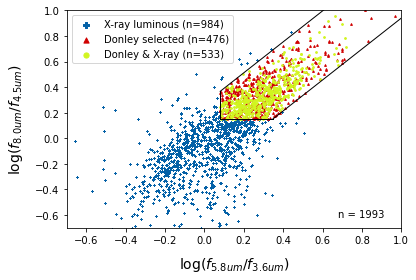

Number of IR only:	 476
Number of Xray only:	 984
Number of matches:	 533
Total Number:		 1993
64.86486486486487 % of Xray sources fall outside wedge.
47.17542120911794 % of IR souces have no Xray greater than 10^43


In [23]:
myP.PlotDonleyTricolor(
        x_xr_24um, y_xr_24um,             # X-ray (blue)
        x_ir_24um, y_ir_24um,             # infrared (red)
        x_ix_24um, y_ix_24um,             # overlap (yellow)
        path=path_fig,                              # save
        fileName='COSMOS_IR-Xray_selection_24um',   # save
        printInfo=True          # output text
    ) 

In [24]:
# match redshift against AGN color IDs
key_z_blu24, key_blu24_z= match.match(zID_01, agn_xrSel20_id_ONLY_IRAC_24um) 
key_z_red24, key_red24_z= match.match(zID_01, agn_irSel20_id_ONLY_IRAC_24um)
key_z_yel24, key_yel24_z= match.match(zID_01, agn20_id_BOTH_IRAC_24um)     

# get sources with redshifts 0<z<1
x_xr_24um_z01 = x_xr_24um[key_blu24_z]
y_xr_24um_z01 = y_xr_24um[key_blu24_z]
x_ir_24um_z01 = x_ir_24um[key_red24_z] 
y_ir_24um_z01 = y_ir_24um[key_red24_z]
x_ix_24um_z01 = x_ix_24um[key_yel24_z] 
y_ix_24um_z01 = y_ix_24um[key_yel24_z]

# print info 
print('Number of IR only w/ IRAC and 0<z<1:\t',   len(x_ir_24um_z01))
print('Number of Xray only w/ IRAC and 0<z<1:\t', len(x_xr_24um_z01))
print('Number of matches w/ IRAC and 0<z<1:\t',   len(x_ix_24um_z01))

Number of IR only w/ IRAC and 0<z<1:	 93
Number of Xray only w/ IRAC and 0<z<1:	 276
Number of matches w/ IRAC and 0<z<1:	 86


In [25]:
# initialize list of all True 
b_no24_mask = np.ones(len(agn_xrSel20_id_ONLY_IRAC_24um), dtype=bool)
r_no24_mask = np.ones(len(agn_irSel20_id_ONLY_IRAC_24um), dtype=bool)
y_no24_mask = np.ones(len(agn20_id_BOTH_IRAC_24um)      , dtype=bool)
# set sources with 24um matches to False
b_no24_mask[key_blu24_z] = False
r_no24_mask[key_red24_z] = False
y_no24_mask[key_yel24_z] = False
# apply masks 
x_xr_no24um_z01 = x_xr_24um[b_no24_mask]
y_xr_no24um_z01 = y_xr_24um[b_no24_mask]
x_ir_no24um_z01 = x_ir_24um[r_no24_mask]
y_ir_no24um_z01 = y_ir_24um[r_no24_mask]
x_ix_no24um_z01 = x_ix_24um[y_no24_mask]
y_ix_no24um_z01 = y_ix_24um[y_no24_mask]
# print info 
print('Number of IR only w/ IRAC and z>1:\t',   len(x_ir_no24um_z01))
print('Number of Xray only w/ IRAC and z>1:\t', len(x_xr_no24um_z01))
print('Number of matches w/ IRAC and z>1:\t',   len(x_ix_no24um_z01))

Number of IR only w/ IRAC and z>1:	 383
Number of Xray only w/ IRAC and z>1:	 708
Number of matches w/ IRAC and z>1:	 447


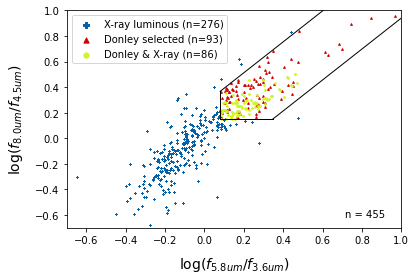

Number of IR only:	 93
Number of Xray only:	 276
Number of matches:	 86
Total Number:		 455
76.24309392265194 % of Xray sources fall outside wedge.
51.955307262569825 % of IR souces have no Xray greater than 10^43


In [26]:
myP.PlotDonleyTricolor(
        x_xr_24um_z01, y_xr_24um_z01,             # X-ray (blue)
        x_ir_24um_z01, y_ir_24um_z01,             # infrared (red)
        x_ix_24um_z01, y_ix_24um_z01,             # overlap (yellow)
        path=path_fig,                                  # save
        fileName='COSMOS_IR-Xray_selection_24um_z01',   # save
        printInfo=True          # output text
    ) 

In [27]:
# myP.PlotDonleyTricolor(
#         x_xr_no24um_z01, y_xr_no24um_z01,             # X-ray (blue)
#         x_ir_no24um_z01, y_ir_no24um_z01,             # infrared (red)
#         x_ix_no24um_z01, y_ix_no24um_z01,             # overlap (yellow)
#         path=path_fig,                                # save
#         fileName='',   # save
#         printInfo=True          # output text
#     ) 

# Match Xray Data to IRAC Datapoints

In [28]:
## Build full agn lists:
##      agn_full_ids
##      agn_full_i20

# merge agn lists into one
agn_full_ids = np.unique(np.concatenate((agn_irSel20_id,agn_xrSel20_id)))

# match full agn list against COSMOS 2020 to get i
key_full20, agn_full_i20 = match.match(agn_full_ids, id20_data)


In [29]:
## Build xray matched agn lists:
##      agn_yX_ids
##      agn_yX_i16
##      agn_yX_i20

# match full agn list against Chandra 2016 to get id and i for xray data 
key_full16, agn_yX_i16 = match.match(agn_full_ids, id16_data)

# get list of agn with xray matches 
agn_yX_ids = agn_full_ids[key_full16]

# match xray data agn against COSMOS 2020 to get i for xray list 
key_yxid, agn_yX_i20 = match.match(agn_yX_ids, id20_data)

In [30]:
## Build no-xray matched agn lists:
##      agn_nX_ids
##      agn_nX_i20

# match agn with xray against the full list to get index matches
key_yx, key_full = match.match(agn_yX_ids, agn_full_ids)

# create mask that is false for any xray matches 
mask_nX = np.ones(agn_full_ids.size, dtype=bool)
mask_nX[key_full] = False

# apply mask to get lists with no xray data 
agn_nX_ids = agn_full_ids[mask_nX]
agn_nX_i20 = agn_full_i20[mask_nX]

In [31]:
# print information 
print('Number of total AGN:\t\t\t',         len(agn_full_ids))
print('Number of AGN with Xray data:\t\t',  len(agn_yX_ids))
print('Number of AGN without Xray data:\t', len(agn_nX_ids))
# print('(Note that values may be -99)')

Number of total AGN:			 3062
Number of AGN with Xray data:		 2263
Number of AGN without Xray data:	 799


In [32]:
# get xray data
L0510_agn = L0510_data[agn_yX_i16]
k0510_agn = k0510_data[agn_yX_i16]
Lx = L0510_agn - np.log10(k0510_agn) # k_abs = L_abs / L_int --> log(L_int) = log(L_abs) - log(k_abs)

# get masks for (in)valid data 
mask_goodX = Lx > 0 
mask_badX = ~ mask_goodX

# apply mask for valid data
agn_yX_ids_Xmasked = agn_yX_ids[mask_goodX]
agn_yX_i16_Xmasked = agn_yX_i16[mask_goodX]
agn_yX_i20_Xmasked = agn_yX_i20[mask_goodX]
Lx_Xmasked         = Lx[mask_goodX]

# apply invalid mask to get the removed ids/i20 
kicked_ids = agn_yX_ids[mask_badX]
kicked_i20 = agn_yX_i20[mask_badX]
print('Kicked from yX:', len(kicked_ids))

# add the removed yX ids/i20s to nX arrays
agn_nX_ids_Xmasked = np.concatenate((agn_nX_ids, kicked_ids))
agn_nX_i20_Xmasked = np.concatenate((agn_nX_i20, kicked_i20))


Kicked from yX: 66


C:\Users\polar\AppData\Local\Temp\ipykernel_12748\1411070485.py:4: RuntimeWarning: invalid value encountered in log10
  Lx = L0510_agn - np.log10(k0510_agn) # k_abs = L_abs / L_int --> log(L_int) = log(L_abs) - log(k_abs)


In [33]:
# print information 
print('Number of total AGN:\t\t\t',         len(agn_full_ids))
print('Number of AGN with Xray data:\t\t',  len(agn_yX_ids_Xmasked))
print('Number of AGN without Xray data:\t', len(agn_nX_ids_Xmasked))

Number of total AGN:			 3062
Number of AGN with Xray data:		 2197
Number of AGN without Xray data:	 865


In [34]:
# Get unmasked IRAC data
ch1_yX, ch2_yX, ch3_yX, ch4_yX, mask_yX = SelectIRAC(agn_yX_i20_Xmasked, True, True) 
ch1_nX, ch2_nX, ch3_nX, ch4_nX, mask_nX = SelectIRAC(agn_nX_i20_Xmasked, True, True) 

Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 1.2382095 	 2890.8818 	 2046
CH2 	 2.9999146 	 2585.7314 	 2046
CH3 	 0.7995982 	 4258.4307 	 2046
CH4 	 0.62190974 	 6295.71 	 2046
-------------------------------------------------------------
Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 0.06996247 	 557.9681 	 865
CH2 	 0.027118225 	 1051.9921 	 865
CH3 	 0.3748381 	 2789.9287 	 865
CH4 	 0.37653038 	 5239.906 	 865
-------------------------------------------------------------


In [35]:
# apply mask to Xray data
Lx_IXmasked = Lx_Xmasked[mask_yX]

# apply mask to yX lists
agn_yX_ids_IXmasked = agn_yX_ids_Xmasked[mask_yX]
agn_yX_i16_IXmasked = agn_yX_i16_Xmasked[mask_yX]
agn_yX_i20_IXmasked = agn_yX_i20_Xmasked[mask_yX]

# apply mask to nX lists
agn_nX_ids_IXmasked = agn_nX_ids_Xmasked[mask_nX]
agn_nX_i20_IXmasked = agn_nX_i20_Xmasked[mask_nX]

# Plot IRAC Colors With Xray Color Bar

In [36]:
# calculate colors for with Xray
x_yX = np.log10( ch3_yX / ch1_yX ) # x = log10 ( f_5.6um / f_3.6um )
y_yX = np.log10( ch4_yX / ch2_yX ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for without Xray
x_nX = np.log10( ch3_nX / ch1_nX ) # x = log10 ( f_5.6um / f_3.6um )
y_nX = np.log10( ch4_nX / ch2_nX ) # y = log10 ( f_8.0um / f_4.5 um )

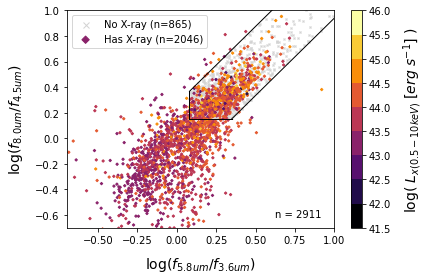

Number with Xray:	 2046
Number without Xray:	 865
Total Number:		 2911


In [37]:
myP.PlotDonleyXray(
        x_nX, y_nX,             # no X-ray detections 
        x_yX, y_yX,             # yes X-ray detections
        Lx_IXmasked,            # X-ray luminosity (colorbar)
        path=path_fig,          # save
        fileName='COSMOS_IR-Xray_XrayColorBar',   # save
        printInfo=True          # output text
    )

# Isolate by Redshifts 0<z<1

In [38]:
# match redshift against AGN color IDs
key_z_yX, key_yX_z= match.match(zID_01, agn_yX_ids_IXmasked) 
key_z_nY, key_nX_z= match.match(zID_01, agn_nX_ids_IXmasked)

# get sources with redshifts 0<z<1
Lx_IXmasked_z01 = Lx_IXmasked[key_yX_z]
x_yX_z01 = x_yX[key_yX_z]
y_yX_z01 = y_yX[key_yX_z]
x_nX_z01 = x_nX[key_nX_z] 
y_nX_z01 = y_nX[key_nX_z]

# print info 
print('Number with Xray and 0<z<1:\t',   len(x_yX_z01))
print('Number without Xray and 0<z<1:\t', len(x_nX_z01))

Number with Xray and 0<z<1:	 479
Number without Xray and 0<z<1:	 254


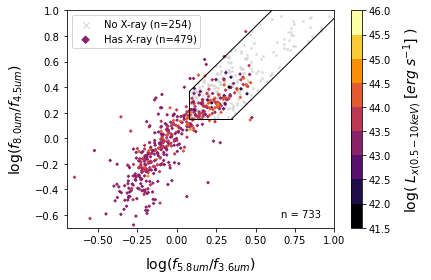

Number with Xray:	 479
Number without Xray:	 254
Total Number:		 733


In [39]:
myP.PlotDonleyXray(
        x_nX_z01, y_nX_z01,     # no X-ray detections 
        x_yX_z01, y_yX_z01,     # yes X-ray detections
        Lx_IXmasked_z01,        # X-ray luminosity (colorbar)
        path=path_fig,          # save
        fileName='COSMOS_IR-Xray_XrayColorBar_z01',   # save
        printInfo=True          # output text
    )

# Plot for 24um

In [40]:
# match sources with 24um to y/nX AGN 
key_id24_yX, key_yX_id24 = match.match(id20_data_fir24SmallErr, agn_yX_ids_IXmasked)
key_id24_nX, key_nX_id24 = match.match(id20_data_fir24SmallErr, agn_nX_ids_IXmasked)

# Get IDs of AGN with 24um detections. 
agn_yX_ids_IXmasked_24um = agn_yX_ids_IXmasked[key_yX_id24]
agn_nX_ids_IXmasked_24um = agn_nX_ids_IXmasked[key_nX_id24]

# get x and y points for AGN with 24um
Lx_IXmasked_24um = Lx_IXmasked[key_yX_id24]
x_yX_24um = x_yX[key_yX_id24]
y_yX_24um = y_yX[key_yX_id24]
x_nX_24um = x_nX[key_nX_id24]
y_nX_24um = y_nX[key_nX_id24]

# print info 
print('Number with Xray and 24um:\t',    len(x_yX_24um))
print('Number without Xray and 24um:\t', len(x_nX_24um))

Number with Xray and 24um:	 1532
Number without Xray and 24um:	 461


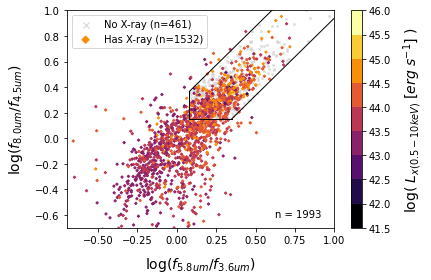

Number with Xray:	 1532
Number without Xray:	 461
Total Number:		 1993


In [41]:
myP.PlotDonleyXray(
        x_nX_24um, y_nX_24um,     # no X-ray detections 
        x_yX_24um, y_yX_24um,     # yes X-ray detections
        Lx_IXmasked_24um,         # X-ray luminosity (colorbar)
        path=path_fig,            # save
        fileName='COSMOS_IR-Xray_XrayColorBar_24um',   # save
        printInfo=True           # output text
    )

In [42]:
# match redshift against AGN color IDs
key_z_yX24, key_yX24_z= match.match(zID_01, agn_yX_ids_IXmasked_24um) 
key_z_nY24, key_nX24_z= match.match(zID_01, agn_nX_ids_IXmasked_24um)

# get sources with redshifts 0<z<1
Lx_IXmasked_24um_z01 = Lx_IXmasked_24um[key_yX24_z]
x_yX_24um_z01 = x_yX_24um[key_yX24_z]
y_yX_24um_z01 = y_yX_24um[key_yX24_z]
x_nX_24um_z01 = x_nX_24um[key_nX24_z] 
y_nX_24um_z01 = y_nX_24um[key_nX24_z]

# print info 
print('Number with Xray, 24um, and 0<z<1:\t',    len(x_yX_24um_z01))
print('Number without Xray, 24um, and 0<z<1:\t', len(x_nX_24um_z01))

Number with Xray, 24um, and 0<z<1:	 377
Number without Xray, 24um, and 0<z<1:	 78


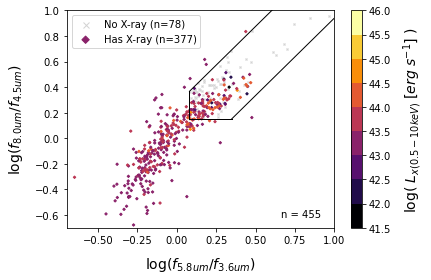

Number with Xray:	 377
Number without Xray:	 78
Total Number:		 455


In [43]:
myP.PlotDonleyXray(
        x_nX_24um_z01, y_nX_24um_z01,     # no X-ray detections 
        x_yX_24um_z01, y_yX_24um_z01,     # yes X-ray detections
        Lx_IXmasked_24um_z01,             # X-ray luminosity (colorbar)
        path=path_fig,                    # save
        fileName='COSMOS_IR-Xray_XrayColorBar_24um_z01',   # save
        printInfo=True           # output text
    )

# Plot Histogram of Xray Luminosity

In [44]:
# myP.PlotHistOne(x=Lx_IXmasked)

In [45]:
def SplitInOutWedge(x,y,toMask) : 
    # get mask of sources inside Donley Wedeg
    mask_inWedge = myP.SourcesInDonleyWedge(x,y)
    # apply mask to separate Lx
    inWedge  = toMask[mask_inWedge]
    outWedge = toMask[~mask_inWedge]
    return inWedge,outWedge

Number of x1:	 668
Number of x2:	 1378
Range x1:	 41.887 - 45.646275
Range x2:	 43.000263 - 45.4326


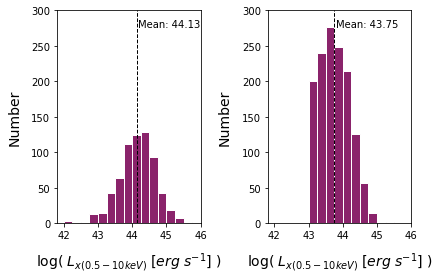

In [46]:
# get Lx inside and outside of wedge
Lx_IXmasked_inWedge, Lx_IXmasked_outWedge = SplitInOutWedge(x_yX,y_yX,Lx_IXmasked)
# plot
myP.PlotHistTwo(Lx_IXmasked_inWedge,Lx_IXmasked_outWedge,saveStr=path_fig+'\COSMOS_IR-Xray_XrayHist_split.png')

Number of x1:	 548
Number of x2:	 984
Range x1:	 41.887 - 45.410076
Range x2:	 43.000263 - 44.974


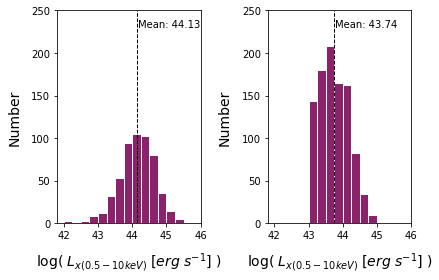

In [47]:
# get Lx inside and outside of wedge
Lx_IXmasked_inWedge_24um, Lx_IXmasked_outWedge_24um = SplitInOutWedge(x_yX_24um,y_yX_24um,Lx_IXmasked_24um)
# plot
myP.PlotHistTwo(Lx_IXmasked_inWedge_24um,Lx_IXmasked_outWedge_24um,h=250,saveStr=path_fig+'\COSMOS_IR-Xray_XrayHist_split_24um.png')

Number of x1:	 101
Number of x2:	 276
Range x1:	 41.887 - 44.664
Range x2:	 43.003 - 44.583683


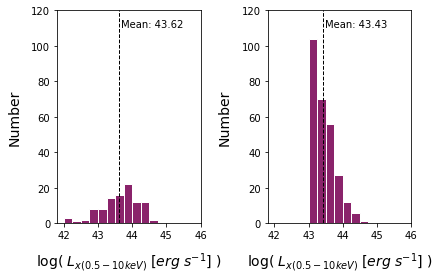

In [48]:
# get Lx inside and outside of wedge
Lx_IXmasked_inWedge_24um_z01, Lx_IXmasked_outWedge_24um_z01 = SplitInOutWedge(x_yX_24um_z01,y_yX_24um_z01,Lx_IXmasked_24um_z01)
# plot
myP.PlotHistTwo(Lx_IXmasked_inWedge_24um_z01,Lx_IXmasked_outWedge_24um_z01,h=120,saveStr=path_fig+'\COSMOS_IR-Xray_XrayHist_split_24um_z01.png')

# Dual-data plots

In [54]:
# plot 3 types of AGN on Donley IRAC color-color plot
def PlotDonleyTricolor_Dual(
    
        x_xr_z, y_xr_z,         # X-ray (blue) with z
        x_ir_z, y_ir_z,         # infrared (red) with z
        x_ix_z, y_ix_z,         # overlap (yellow) with z

        x_xr, y_xr,             # X-ray (blue)
        x_ir, y_ir,             # infrared (red)
        x_ix, y_ix,             # overlap (yellow)

        path='', fileName='',   # save
        saveNum=2,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
        printInfo=True          # output text
    ) :

    # plot data
    plt.scatter(x_xr, y_xr, marker='s', c=myP.c_xray   , edgecolors='#023A65', s=10, label='X-ray luminous (n='+str(len(x_xr))+')')
    plt.scatter(x_ir, y_ir, marker='^', c=myP.c_ir     , edgecolors='#7B0000', s=10, label='Donley selected (n='+str(len(x_ir))+')')
    plt.scatter(x_ix, y_ix, marker='o', c=myP.c_ir_xray, edgecolors='#849E05', s=10, label='Donley & X-ray (n='+str(len(x_ix))+')')

    # '#023A65'
    # '#7B0000'   
    # '#849E05'   

    # plot z data
    plt.scatter(x_xr_z, y_xr_z, marker='s', c=myP.c_xray   ,  edgecolors='#3AA7FA', s=10, label='X-ray luminous (n='+str(len(x_xr_z))+')')
    plt.scatter(x_ir_z, y_ir_z, marker='^', c=myP.c_ir     ,  edgecolors='#FF4A4A', s=10, label='Donley selected (n='+str(len(x_ir_z))+')')
    plt.scatter(x_ix_z, y_ix_z, marker='o', c=myP.c_ir_xray,  edgecolors='#E3F979', s=10, label='Donley & X-ray (n='+str(len(x_ix_z))+')')
    
    # '#1396FA'
    # '#FF1A1A'
    # '#D9F939'

    # myP.c_xray    
    # myP.c_ir      
    # myP.c_ir_xray 

    # plotting class
    myP.PlotDonleyWedge(linewidth=1)
    myP.addtext_n(len(x_ir)+len(x_xr)+len(x_ix)+len(x_ir_z)+len(x_xr_z)+len(x_ix_z))

    # save
    if(path and fileName) :
        # if(saveNum>=3) : 
        #     plt.axis([-1.5,2.5,-1.5,2.5]) 
        #     myP.save(path+'\\'+fileName+'_FULL.png')
        # if(saveNum>=2) : 
        #     plt.axis([-0.7,1.0,-0.7,1.0]) 
        #     myP.save(path+'\\'+fileName+'_ZOOM.png')
        if(saveNum>=1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            # plt.legend(markerscale=3)
            myP.save(path+'\\'+fileName+'_ZOOM_legend.png')
        if(saveNum<1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            # plt.legend(markerscale=3)
    else :
        plt.axis([-0.7,1.0,-0.7,1.0]) 
        # plt.legend(markerscale=3) 

    # display
    plt.show()


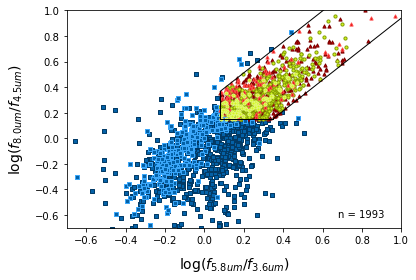

In [55]:
PlotDonleyTricolor_Dual(
        x_xr_24um_z01, y_xr_24um_z01,             # X-ray (blue)
        x_ir_24um_z01, y_ir_24um_z01,             # infrared (red)
        x_ix_24um_z01, y_ix_24um_z01,             # overlap (yellow)

        x_xr_no24um_z01, y_xr_no24um_z01,         # X-ray (blue)
        x_ir_no24um_z01, y_ir_no24um_z01,         # infrared (red)
        x_ix_no24um_z01, y_ix_no24um_z01,         # overlap (yellow)

        path=path_fig,                              # save
        fileName='COSMOS_IR-Xray_selection_dual',   # save
        saveNum=1,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
        printInfo=False         # output text
    )

# Write Important IDs to CSV

In [51]:
# write IDs of AGN by selection method to file
with open(path_csv+'\ID_RedYelBlu_AGNselection.csv', mode='w', newline='') as csv_file :
    # initialize csv
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write to file 
    writer.writerow([   'Row 1 = red IR selected AGN. '+
                        'Row 2 = yellow both IR-Xray AGN. '+
                        'Row 3 = blue X-ray selected AGN. '+

                        'Row 4 = blue X-ray selected AGN with IRAC detections. '+
                        'Row 5 = blue X-ray selected AGN without IRAC detections. '+

                        'Row 6 = red IR selected AGN with 24um detection. '
                        'Row 7 = yellow both IR-Xray AGN with 24um detection. '+
                        'Row 8 = blue X-ray selected AGN with 24um and IRAC detections. '+
                        
                        'Values are ID_COSMOS2015.'
                    ])
    # AGN colors
    writer.writerow(agn_irSel20_id_ONLY)            # 1
    writer.writerow(agn20_id_BOTH)                  # 2
    writer.writerow(agn_xrSel20_id_ONLY)            # 3
    # Reduced X-ray by IRAC     
    writer.writerow(agn_xrSel20_id_ONLY_IRAC)       # 4
    writer.writerow(agn_xrSel20_id_ONLY_NOIRAC)     # 5
    # AGN colors with IRAC and 24um detections
    writer.writerow(agn_irSel20_id_ONLY_IRAC_24um)  # 6
    writer.writerow(agn20_id_BOTH_IRAC_24um)        # 7
    writer.writerow(agn_xrSel20_id_ONLY_IRAC_24um)  # 8

# confirm 
print('List saved: ID_RedYelBlu_AGNselection.csv')

List saved: ID_RedYelBlu_AGNselection.csv
